In [1]:
http://ahmedas91.github.io/blog/2016/03/01/efficient-frontier-with-python/

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

import datetime
import numpy as np
import pandas_datareader.data as web
import pandas as pd
from scipy.stats import norm

# Turn off progress printing 
solvers.options['show_progress'] = False

In [35]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [4]:
#stocks in our portfolio
stocks = ['AAPL','MSFT','AMZN','YHOO']

#pull the price data for each stock
data = web.DataReader(stocks, data_source = 'google', start = '01/01/2010')['Close']

#convert daily stock prices into daily returns
returns = data.pct_change()

#calculate mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

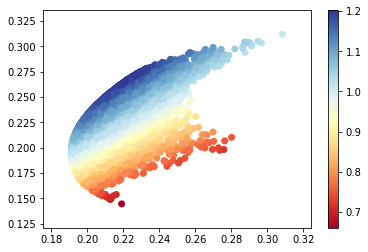

In [5]:
#Number of random portfolio weights to test
num_portfolios = 25000

#set up array to hold results
results = np.zeros((3,num_portfolios))

for i in xrange(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.random.random(4)
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #Store Sharpe Ratio (return / vol) 
    #risk free rate component excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]
    
#convert results array to a Pandas Dataframe
results_frame = pd.DataFrame(results.T, columns = ['ret','stdev','sharpe'])

#create a scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.colorbar()

In [10]:
returns.fillna(0, axis = 1, inplace = True)

In [36]:
weights, returns, risks = optimal_portfolio(returns)

TypeError: imported array must have 1 or 2 dimensions

In [31]:
print max(returns)
print min(returns)

0.0673255596517
0.0573125801633


C:\Users\jhale\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ValueError: x and y must have same first dimension, but have shapes (1500L,) and (25200L,)

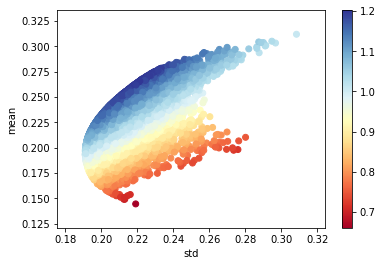

In [14]:
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.colorbar()
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks , returns , 'y-o')